# __RESEARCH QUESTION:__
Question: What factors affect the sale of houses?

In this project, we would like to analyze the housing market in the United States from the years 2018-2013, as well as different social and economic factors (birth and mortality rates, inflation, and unemployment) that could play a role in the sale of houses. We will quantify the \"sale of houses\" by looking at several conditions under which houses in America are sold, such as the length of time on the market and change in price. We will explore the relationships between each of the outside factors and how they play a role in the ease of selling a house. From this, we will be able to predict what time and under what conditions it is best to list a house for sale.

In [1]:
# importing packages
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import duckdb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.model_selection import KFold, cross_val_score

# __Dataset:__

We collected data from several different sources. For each of the factors that we will examine, we acquired a dataset of monthly data in the U.S. regarding that factor.

We then had to reshape our data and merge it into one large dataframe, which is in the file `housing_data_df.csv`.

The full collection and cleaning procedure can be found in the data cleaning appendix, found in the file `DataCleaningAppendix.ipynb` in the Github repository.

In [2]:
housing_data_df = pd.read_csv("housing_data_df.csv")

housing_data_df

,Year,Month,New_Listings,Days_To_Pending,Percent_Sold_Below_List,Sale_To_List_Price_Ratio,Births,Deaths,Inflation_Rate,Unemployment_Rate,Months_Since_Jan_2018
0,2018,jan,NaN,47.0,0.642516,0.982759,314808.0,286744.0,2.1,4.0,0
1,2018,feb,NaN,25.0,0.619052,0.984615,284250.0,236998.0,2.2,4.1,1
2,2018,mar,1421529.0,20.0,0.577498,0.988235,316044.0,248805.0,2.4,4.0,2
3,2018,apr,1500194.0,18.0,0.551780,0.990948,298394.0,233164.0,2.5,4.0,3
4,2018,may,1592414.0,18.0,0.533494,0.993166,320622.0,228772.0,2.8,3.8,4
...,...,...,...,...,...,...,...,...,...,...,...
64,2023,may,880510.0,10.0,0.419565,1.000000,NaN,252046.0,4.0,3.7,64
65,2023,jun,907228.0,11.0,0.399708,1.000000,NaN,240140.0,3.0,3.6,65
66,2023,jul,930911.0,12.0,0.411186,1.000000,NaN,244278.0,3.2,3.5,66
67,2023,aug,950306.0,13.0,0.434983,1.000000,NaN,238615.0,3.7,3.8,67


# __Data Description:__
**What are the observations (rows) and the attributes (columns)?**

Our data is essentially a time series, so each row represents a different month from 
January 2018 – August 2023. The columns represent the different factors that we wish to explore in our analysis. We have one column each for the year and month–these are meant to be the identifiers for each row. Then, we have one column for each of the eight different factors:

- `Num_Listings` represents the number of new listings that were posted in the given month.
- `Days_To_Pending` represents the median amount of time that houses took to go from “listed” to “pending” status (which refers to when the sellers first accept an offer), in days.
- `Percent_Sold_Below_List` represents the percentage of houses that were sold for a price that was below their final listing price.
- `Sale_To_List_Price_Ratio` represents the mean ratio of homes’ sale prices over their final listing prices.
- `Births` represents the number of births   
- `Deaths` represents the number of deaths	
- `Inflation_rate` represents the rate at which prices for goods and services rise
- `unemployment_rate` represents the number of unemployed people as a percentage of the labor force. 

**Why was this dataset created?**

The housing data was all created by the Zillow research team in order to analyze the housing market and make predictions for the future housing market.
	The data from birth_df and mortality_df is from the CDC Wonder, which was developed from the Center for Disease Control and Prevention. Their goal is to make the information collected from the CDC available to the public. 
The data from unemployment_df and inflation_df is from the Bureau of Labor Statistics, which measures the productivity in the U.S economy to support public and private decision making.

**Who funded the creation of the dataset?**

The data that we gathered on birth and mortality rates came from the CDC, so it is from the census and funded by the government and tax revenue. The unemployment rate data came from the Bureau of Labor Statistics, so also a government organization, and the inflation rate data was calculated using data from the Bureau of Labor Statistics as well. The housing data was funded by Zillow’s research department.


**What processes might have influenced what data was observed and recorded and what was not?**

Since our housing data is exclusively from Zillow, an online real estate website, our data does not include any transactions that took place offline. These types of transactions usually take place in more rural areas and are difficult to access. 


**What preprocessing was done, and how did the data come to be in the form that you are using?**

We gathered the data from nine different data tables. Each individual table required downloading and conversion to a pandas dataframe, and some of them required conversion from a .xslx file to a .csv file. After we loaded in all of our data, we needed to reshape and rename the tables in order to be able to merge them (more details in the cleaning section).

**If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?**

A lot of our data can be traced back to the U.S. census, which would involve all American citizens. Participation in the census is required by law (per https://www.census.gov/programs-surveys/censuses.html), and the data is used for government functions as well as keeping track of the general U.S. population.

**Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted on Github, in a Cornell Google Drive or Cornell Box)**
Our raw data can be found in the following links:
- Data on sale of houses (all Zillow data): https://www.zillow.com/research/data/
- Data on unemployment rate: https://data.bls.gov/timeseries/LNS14000000
- Data on inflation: https://www.usinflationcalculator.com/inflation/current-inflation-rates/ 
- Data on births: https://wonder.cdc.gov/natality-expanded-current.html 
- Data on mortality: https://wonder.cdc.gov/ucd-icd10-expanded.html 

The downloaded .csv files can be found in the project repository.


**Are there any errors, sources of noise, or redundancies in the dataset?**

There were missing or empty cells (NaNs) in our dataset. We accounted for these errors by removing them. In the zillow data tables, there was a slight redundancy in that there was a row for the entire country followed by rows for the major cities. The city data comprises almost all country-wide data, as most of the platform’s users are in urban regions.

**Is the dataset self-contained, or does it link to or otherwise rely on external resources?**

All of the data involved in the larger dataset was directly downloaded into files. It is self-contained.

















# __Data Limitations:__

Our question and data set create limitations in our data science project. First, the housing data we collected only accounts for houses listed on Zillow. While Zillow is the most popular electronic real estate website, many housing transactions happen off the web, especially in more rural areas of the country (Ahrefs, 2023). This overrepresentation is why much of their data sets are only available in groupings by metropolises, as urban housing markets only represent part of the real estate market of an entire state. 

Another limitation in the Zillow data relates to which data they collect. We have the median days between when the owner accepts an offer (`Days_To_Pending`), but this only refers to when the seller first decides to proceed with an offer. We don’t have the amount of time from when a house is first listed to when it is officially sold.

We encountered more limitations when gathering data to cross-reference with our Zillow records. In addition to the ones included, we wanted to incorporate more factors, such as divorce, nursing homes, and marriage rates; however, we struggled to find data sets that had intervals in months to match our Zillow Data, which records the months between 2018 and August of 2023. We did not believe we could create accurate assessments with data sets that only had five data points. Furthermore, some of the data sets we collected do not continue past 2022, omitting the months 2023. This limitation will make it challenging to analyze our 2023 Zillow data.

Lastly, there are some columns that are missing data. `New_Listings` doesn't have data for January or February 2018, `Births` stops at December 2022, and `Deaths` stops at December 2021. Also, `Days_To_Pending` is the only column of data that we have regarding housing that contains data for September 2023. This limitation will affect our analyses because we will be working with different size columns. Some columns will have less data that we can use to create regressions.

# __Exploratory Data Analysis:__

First of all, before we begin analyzing our data, we need to address the fact that we are using two columns (`Month` and `Year`) as the unique identifiers for each of our rows. So, we create a list of the two columns concatenated to serve as labels for our graphs and improve readability. We also increased the size of the plot and it's font for better legibility.

In [3]:
housing_date = housing_data_df['Month'].astype(str) + " / " + \
    housing_data_df['Year'].astype(str)

sns.set(rc = {'figure.figsize':(20,8)})
sns.set(font_scale=1.5)

**Distribution of Days to Pending for Each Month from Jan 2018 - Sep 2023**  
First, we want to examine the distribution of the length of time that a house remains listed. From the bar graph below, within each individual year, the time that house goes before pending tends to decrease in the middle of the year, and is higher in the beginning and end of the year. Also, there appears to be a general negative trend in the amount of days before a house is pending as time increases.
As this data is short-term, right now it’s difficult to tell whether this is due to short-term events or if it is part of a larger trend.

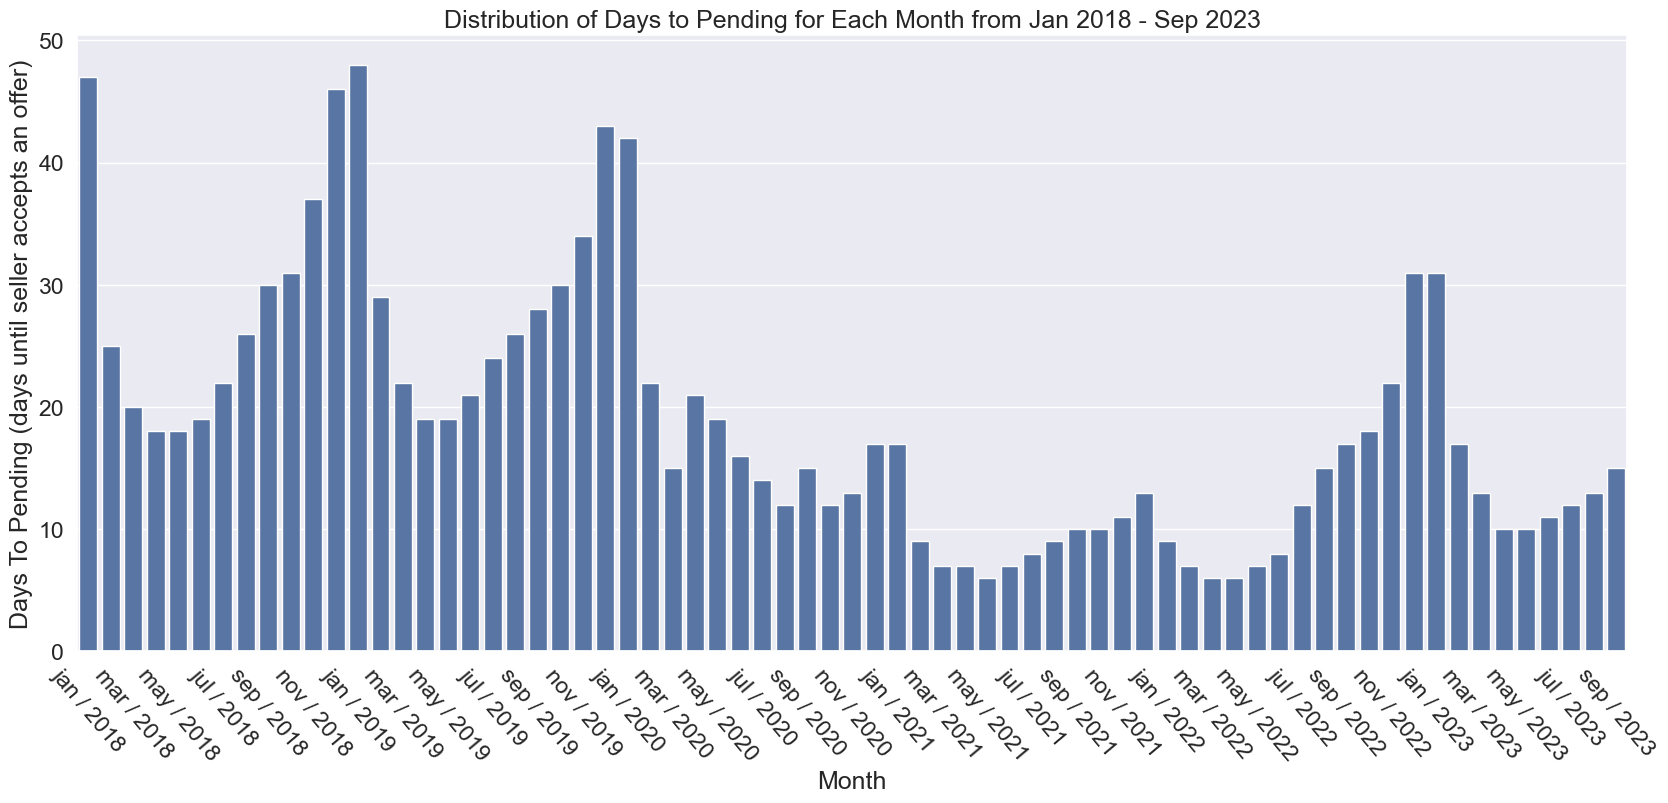

In [4]:
bar = sns.barplot(data=housing_data_df, x=housing_date, \
                  y='Days_To_Pending')
plt.xlabel("Month")
plt.xticks(rotation=-50)
plt.ylabel("Days To Pending (days until seller accepts an offer)")
plt.title("Distribution of Days to Pending for Each Month from Jan 2018 \
- Sep 2023")
plt.setp(bar.get_xticklabels()[1::2], visible=False);

**Days to Pending vs. Sale-to-List Price Ratio**  
We also want to explore the relationships between characteristics about the housing market. So, we will first look at the relationship between how long a house remains for sale and the sale-to-list price ratio. 
The line graph indicates a negative relationship between days to pending and sale-to-list price ratio. As the  number of days it takes from a house’s status to change from listed to pending increases, the ratio of homes sold above their final listing price decreases. 

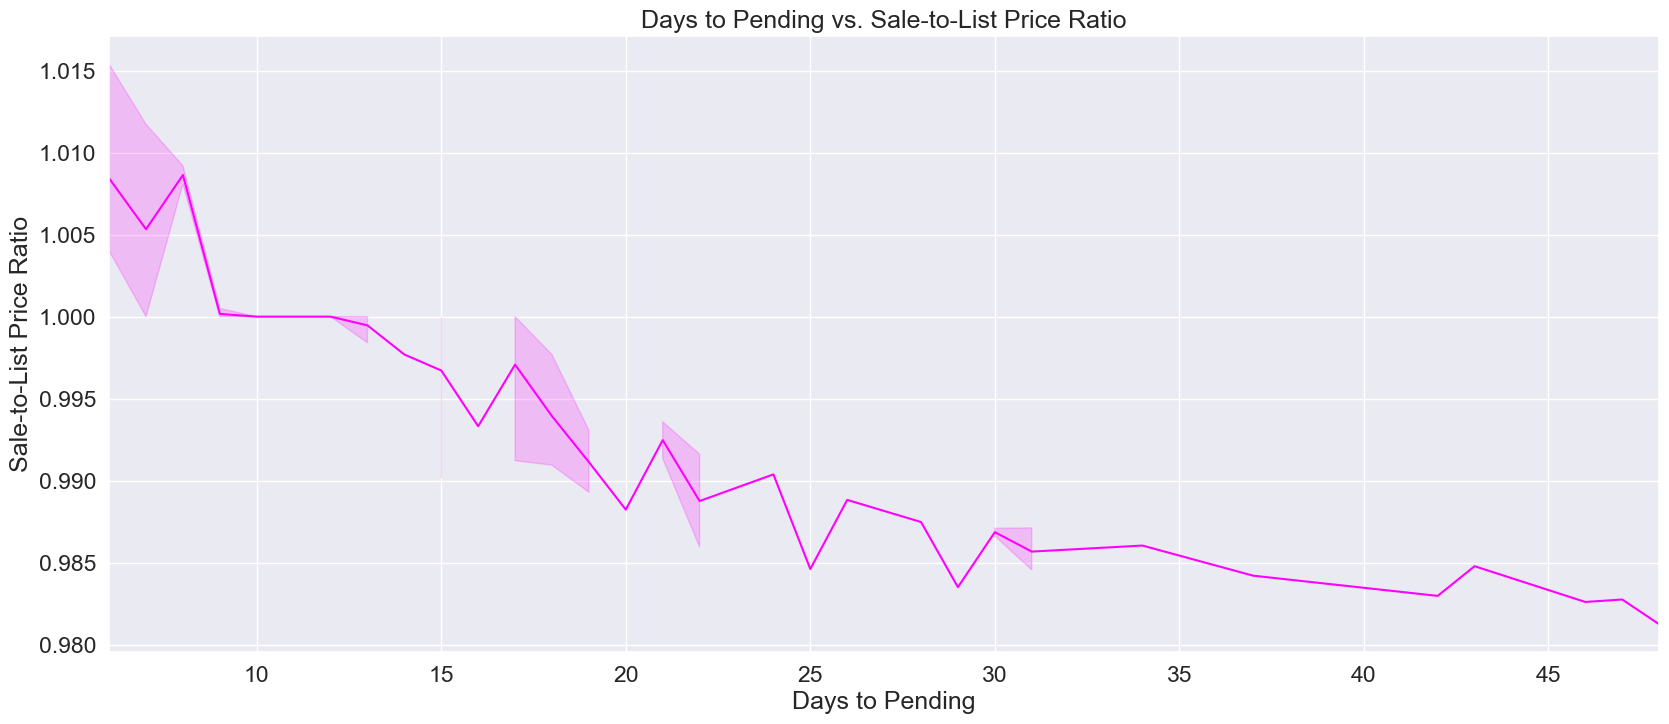

In [5]:
sns.lineplot(data=housing_data_df, x='Days_To_Pending', \
             y='Sale_To_List_Price_Ratio', color='magenta')
plt.title("Days to Pending vs. Sale-to-List Price Ratio")
plt.xlabel("Days to Pending")
plt.ylabel("Sale-to-List Price Ratio")
plt.margins(x=0);

**Number of New Listings Per Number of Deaths**  
Here we want to see if there is a relationship between the number of deaths in a month and the number of new listings. The graph indicates a negative relationship between the number of new listings and the number of deaths. As the number of deaths increase the number of new listings decreases. However, the line fluctuates a lot.

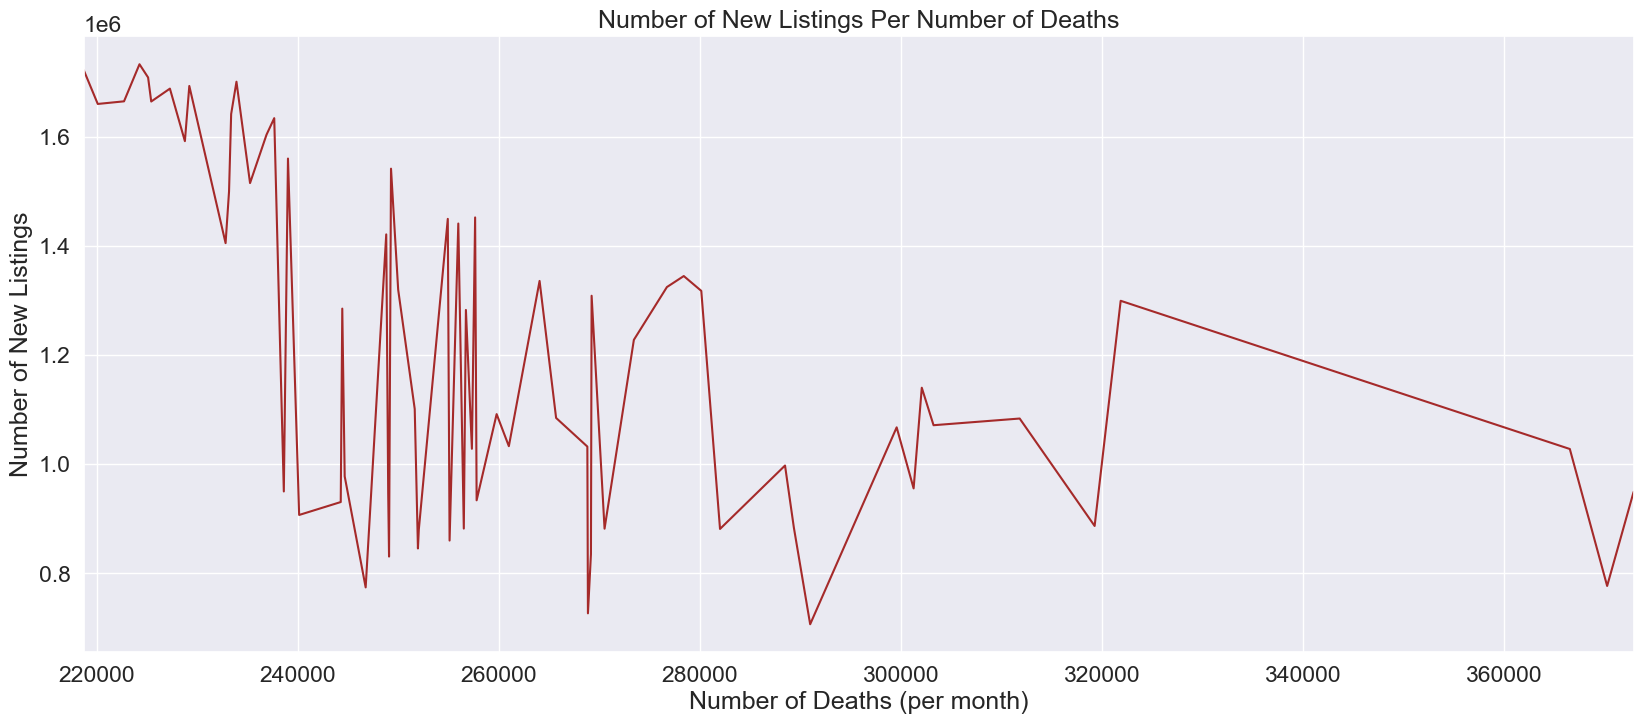

In [6]:
sns.lineplot(data=housing_data_df, x='Deaths', \
             y='New_Listings', color='brown')
plt.title("Number of New Listings Per Number of Deaths")
plt.margins(x=0)
plt.xlabel("Number of Deaths (per month)")
plt.ylabel("Number of New Listings")
plt.xticks(rotation=0);

**Deaths Per Month from Jan 2018 - Nov 2021**  
To gain a better understanding of our data, we will also graph the number of deaths per month. The line graph indicates a positive relationship between time between January 2018 and November 2021 and number of deaths. As the months increased the number of people that died also increased. There was a spike in the number of deaths between February 2020 to June 2021, which was at the height of the Coronavirus pandemic where many people lost their lives. 

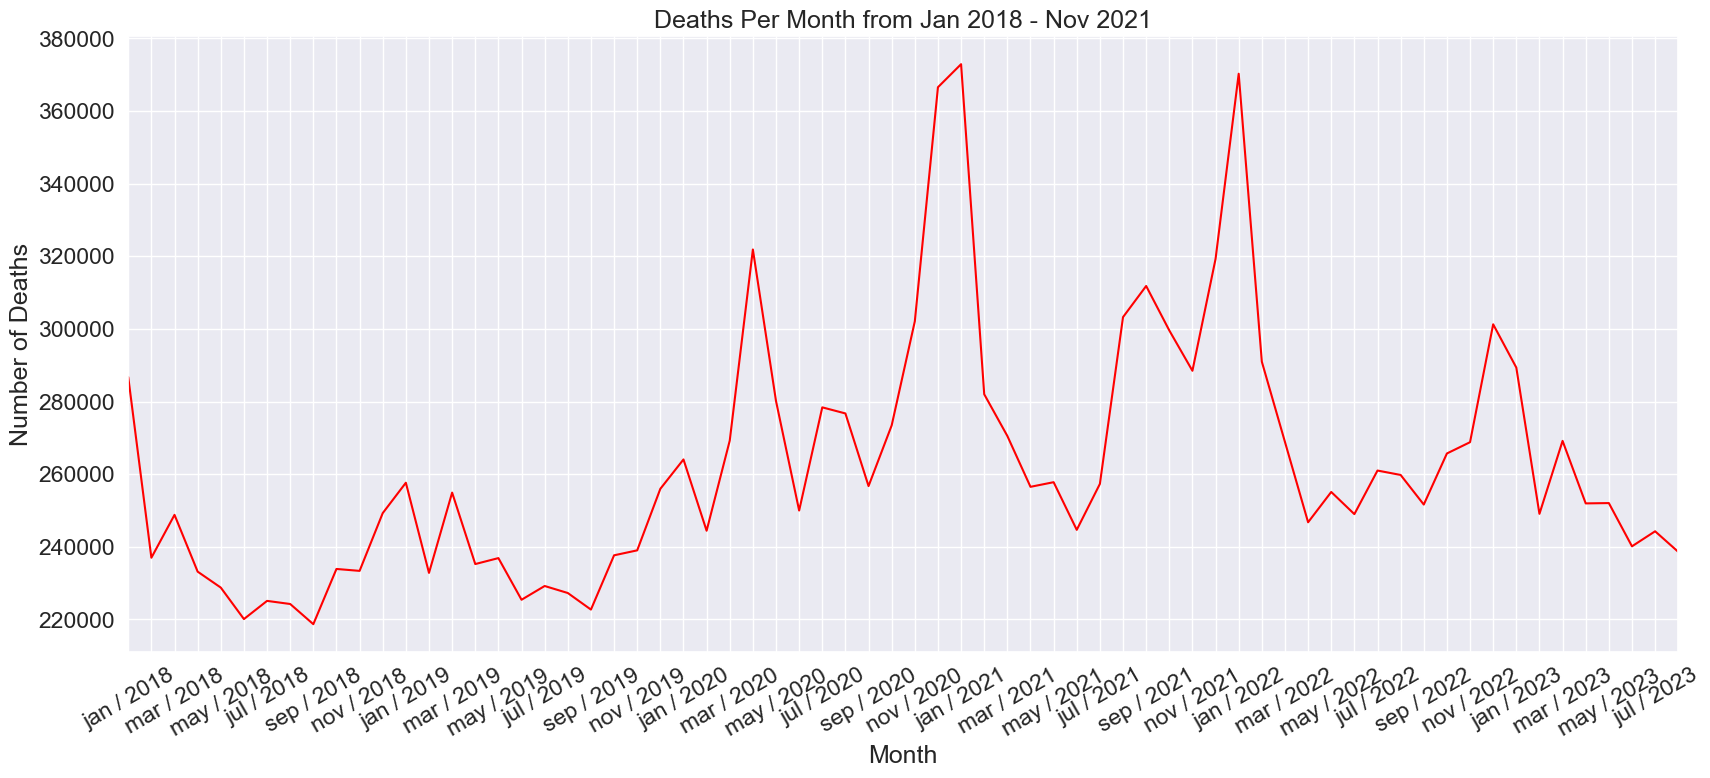

In [7]:
bar = sns.lineplot(data=housing_data_df, x=housing_date, \
             y='Deaths', color='red')
plt.title("Deaths Per Month from Jan 2018 - Nov 2021")
plt.margins(x=0)
plt.xticks(rotation=30)
plt.xlabel("Month")
plt.ylabel("Number of Deaths")
plt.setp(bar.get_xticklabels()[1::2], visible=False);

**Number of New Listings vs. Unemployment Rate**  
We want to see if there is a relationship between unemployment and the number of new listings. The line graph below shows that there isn’t a relationship between the two. It’s interesting to note that there is a large variance from 0–4%, and the graph plateaus past 7% (although there are also less data points at the higher unemployment rates). If we were able to acquire more data for greater rates, we could see if this trend continues.

In [8]:
sns.lineplot(data=housing_data_df, x='unemployment_rate', \
             y='New_Listings', color='orange')
plt.title("Number of New Listings vs. Unemployment Rate")
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("Number of New Listings")
plt.margins(x=0);

ValueError: Could not interpret value `unemployment_rate` for `x`. An entry with this name does not appear in `data`.

**Number of Deaths vs. Percent of Homes Sold Below Initial Price**  
This line graph examines the relationship between the number of deaths and percentage of houses that were sold for a price that was below their final listing price. Our graph indicates that there is no relationship between the two variables. At approximately 241,000 and 259,000 deaths there is an extreme drop in houses sold below their final listing price. 

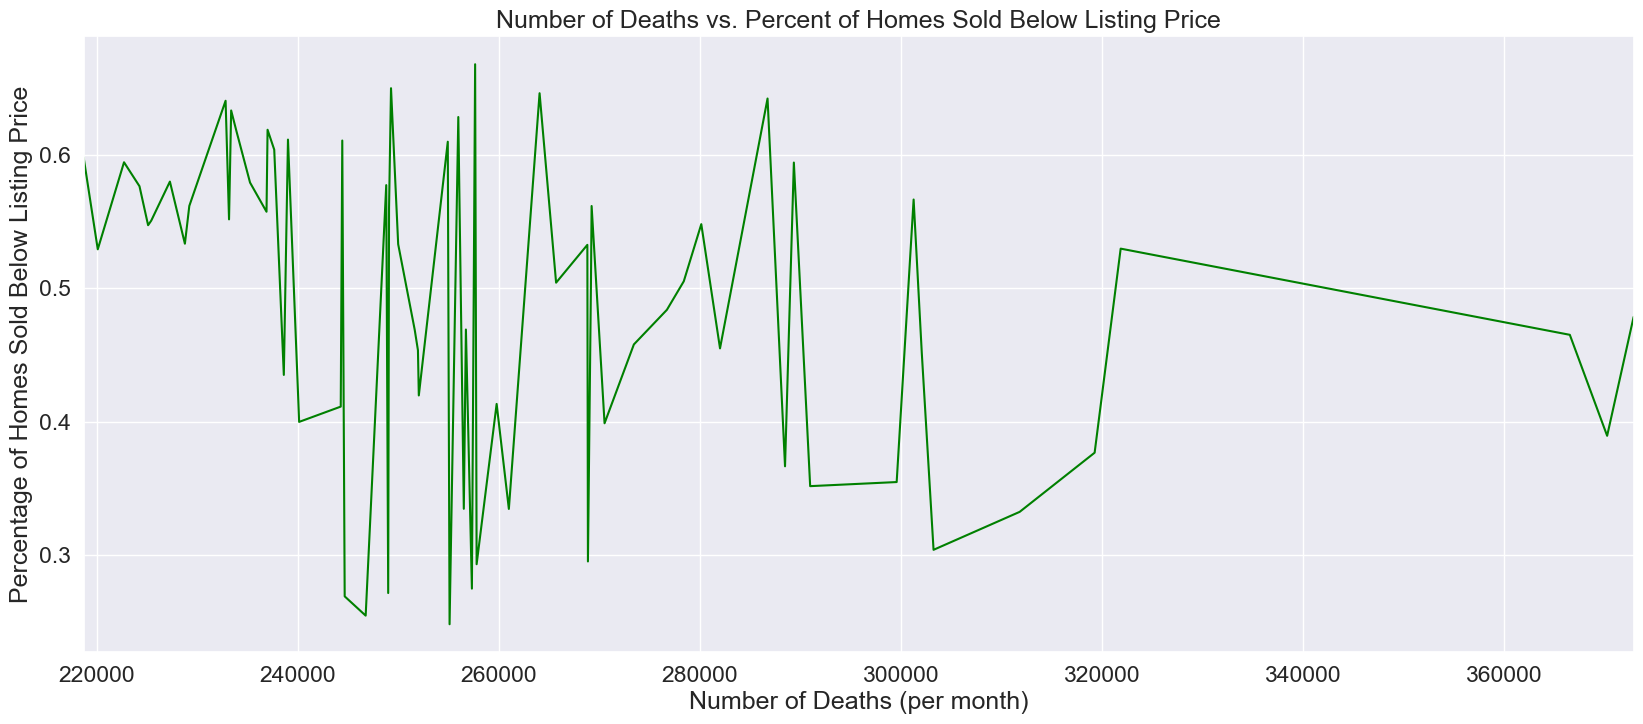

In [9]:
sns.lineplot(data=housing_data_df, x='Deaths', \
             y='Percent_Sold_Below_List', color='green')
plt.title("Number of Deaths vs. Percent of Homes Sold \
Below Listing Price")
plt.xlabel("Number of Deaths (per month)")
plt.ylabel("Percentage of Homes Sold Below Listing Price")
plt.margins(x=0);

**Number of New Listings Per Number of Births**  
Here we want to explore the relationship between the number of new listings and the number of births. The line graph shows that there is a positive relationship between new listings and the number of births. There is a lot of variation in our line graph, but generally as the number of births increase, the number of new listings also increases.  

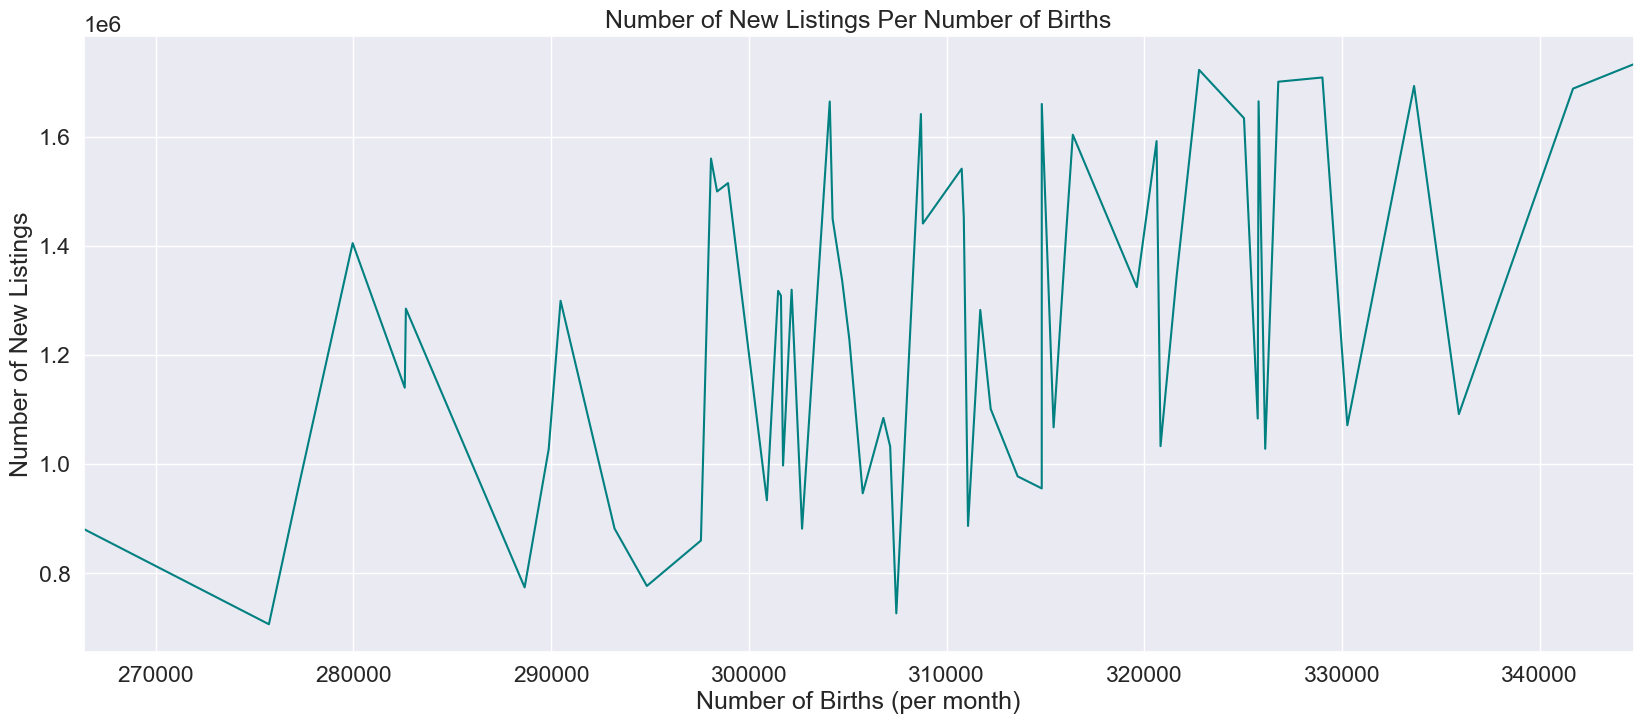

In [10]:
sns.lineplot(data=housing_data_df, x='Births', \
             y='New_Listings', color='teal')
plt.title("Number of New Listings Per Number of Births")
plt.xlabel("Number of Births (per month)")
plt.ylabel("Number of New Listings")
plt.margins(x=0);

**Inflation Rate vs. Perecent of Homes Sold Below Initial Price**  
Now, we want to see if inflation has any relationship with the percentage of houses sold below their final listing price (so if inflation has any possible effect on the value of houses after an offer is made). From the graph, we see that the values vary a lot, so there isn’t a strong relationship. However, there seems to be a general negative trend. So, as inflation increases, generally less houses are sold below their asking price.

In [11]:
sns.lineplot(data=housing_data_df, x='Inflation_rate', \
             y='Percent_Sold_Below_List', color='magenta')
plt.title("Inflation Rate vs. Perecent of Homes Sold Below Listing Price")
plt.xlabel("Inflation Rate (%)")
plt.ylabel("Percentage of Homes Sold Below Listing Price")
plt.margins(x=0);

ValueError: Could not interpret value `Inflation_rate` for `x`. An entry with this name does not appear in `data`.

__Final Takeaways:__
Our analysis did not show any clear, strong relationships between any of our variables. However, we noticed general trends among some of the relationships we looked at. Moving forward, we wish to explore multivariable relationships and other implications of our data.

https://medium.com/geekculture/implement-a-sliding-window-using-python-31d1481842a7

In [12]:
def sliding_window(elm, w_size):
    window = []
    if len(elm) <= w_size:
        return [elements]
    for i in range(len(elm)- w_size + 1):
        window.append(elm[i:i+w_size])
    return window

In [13]:
def window_pred(windows, str1, str2):
    models = []
    preds = []
    for i in range(len(windows)-1):
        model = LinearRegression().fit(windows[i][[str1]], windows[i][[str2]])
        models.append(model)
        p = windows[i+1][str1].reset_index(drop=True)[0]
        preds.append(model.predict([[p]])[0][0])
        
    for x in range(len(windows[-1])):
        preds.insert(0, np.NAN)
    
    return preds

In [14]:
reg_df_1 = housing_data_df[["Births", "New_Listings"]]
reg_df_1 = reg_df_1.dropna().reset_index(drop=True)

windows = sliding_window(reg_df_1, 3)

preds = window_pred(windows, "Births", "New_Listings")

/Users/sanderrodman/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sanderrodman/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sanderrodman/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sanderrodman/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sanderrodman/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/san

In [15]:
reg_df_1["predictions"] = preds
reg_df_1 = reg_df_1.dropna().reset_index(drop=True)
residuals = reg_df_1["New_Listings"] - reg_df_1["predictions"]

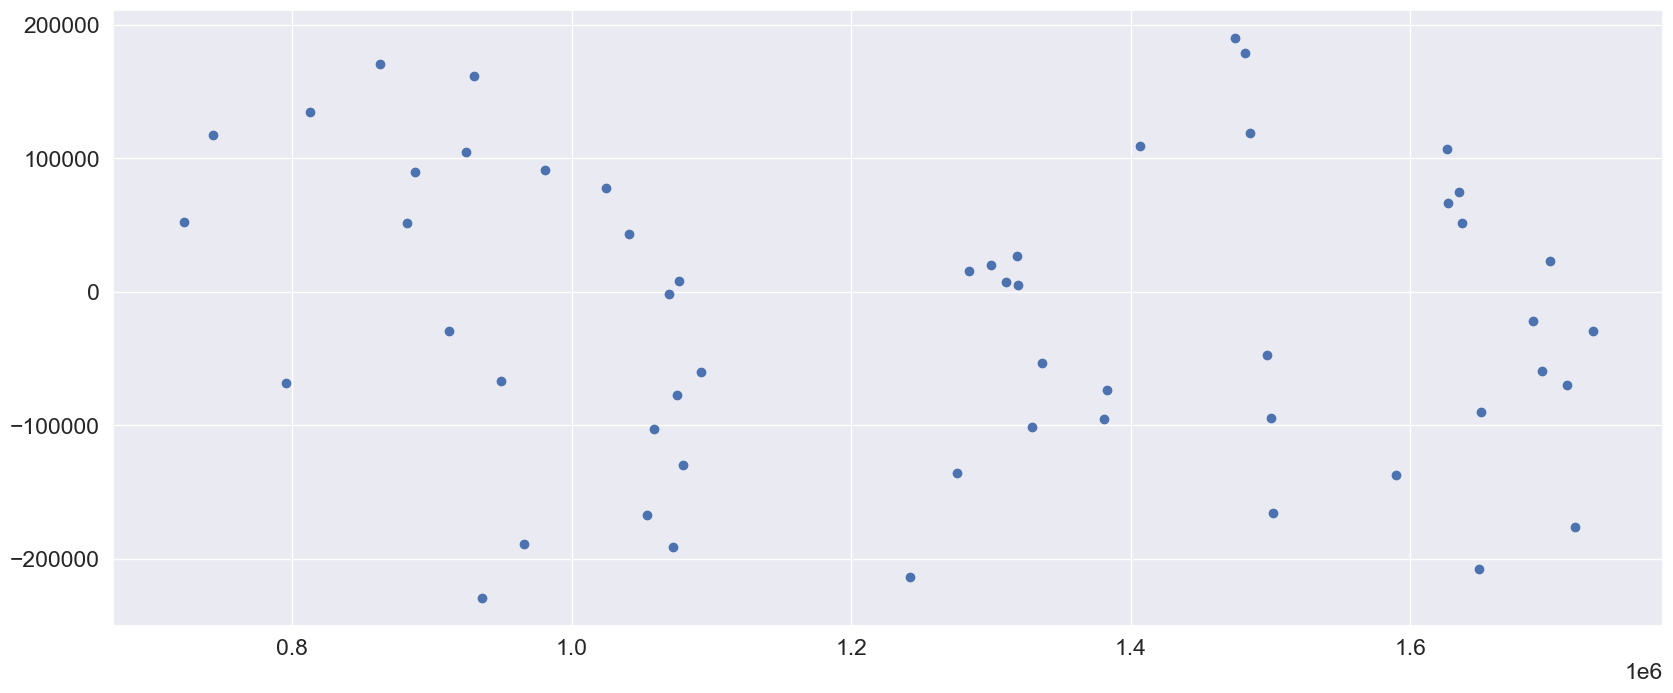

In [16]:
plt.scatter(x=reg_df_1["predictions"], y=residuals)

In [17]:
reg_df_2 = housing_data_df[["Days_To_Pending", "Sale_To_List_Price_Ratio"]]
reg_df_2 = reg_df_2.dropna().reset_index(drop=True)

windows = sliding_window(reg_df_2, 3)
preds = window_pred(windows, "Days_To_Pending", "Sale_To_List_Price_Ratio")

/Users/sanderrodman/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sanderrodman/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sanderrodman/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sanderrodman/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/sanderrodman/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/san

In [18]:
reg_df_2["predictions"] = preds
reg_df_2 = reg_df_2.dropna().reset_index(drop=True)
residuals = reg_df_2["Sale_To_List_Price_Ratio"] - reg_df_2["predictions"]

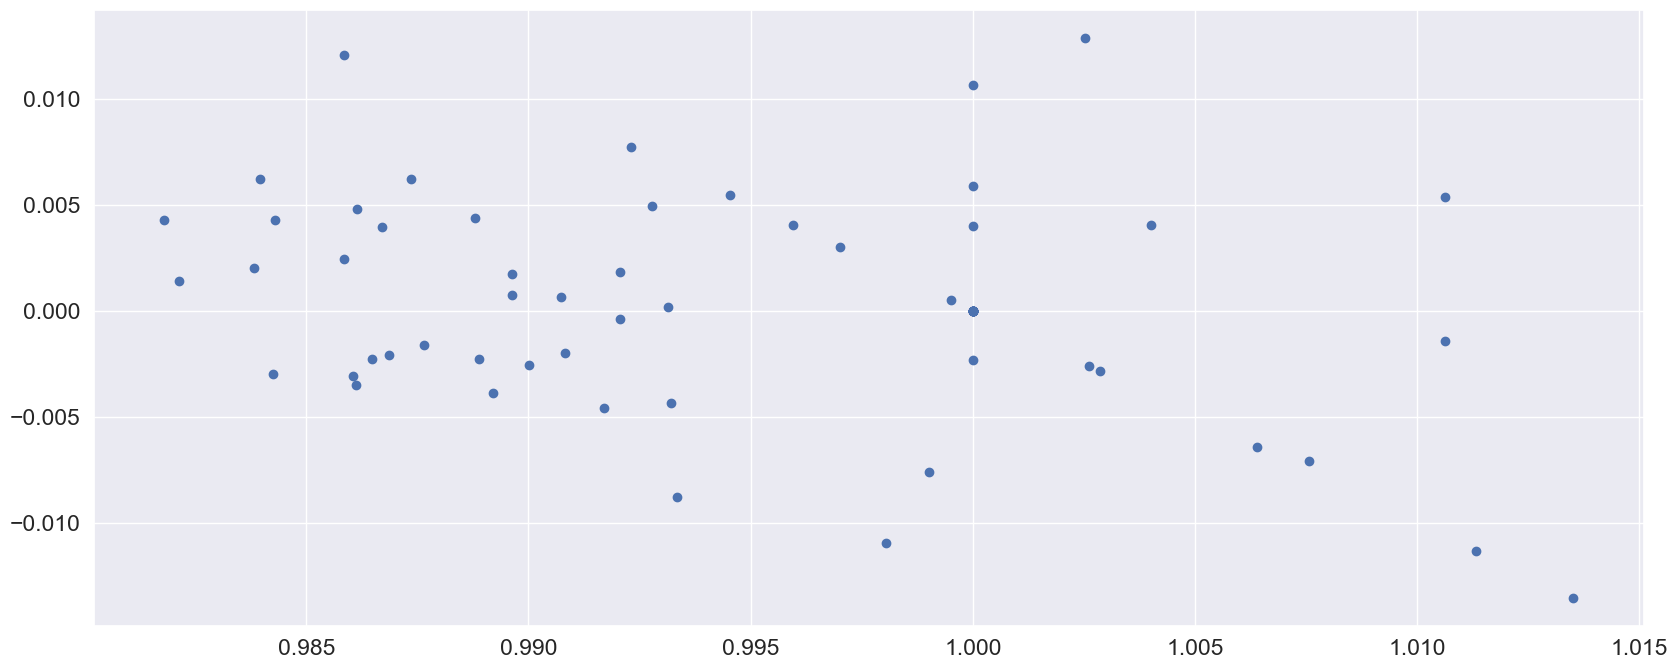

In [19]:
plt.scatter(x=reg_df_2["predictions"], y=residuals)

In [27]:
df_days_to_pending_week = pd.read_csv("median_days_to_pending_week.csv")
df_sale_to_list_week = pd.read_csv("mean_sale_to_list_week.csv")

In [28]:
df_days_to_pending_week = duckdb.sql("SELECT * EXCLUDE ('RegionID', \
 'SizeRank', 'RegionName', 'RegionType', 'StateName') \
 FROM df_days_to_pending_week").df()

average_median_days = df_days_to_pending_week.iloc[0]
df_days_to_pending_week = pd.DataFrame({'Date': average_median_days.index, 'Days_To_Pending': average_median_days})

In [29]:
df_days_to_pending_week['Date'] = pd.to_datetime(df_days_to_pending_week['Date'])
df_days_to_pending_week['Year'] = df_days_to_pending_week['Date'].dt.year
df_days_to_pending_week['Month'] = df_days_to_pending_week['Date'].dt.month
print(df_days_to_pending_week)

                 Date  Days_To_Pending  Year  Month
2018-01-06 2018-01-06             55.0  2018      1
2018-01-13 2018-01-13             51.0  2018      1
2018-01-20 2018-01-20             46.0  2018      1
2018-01-27 2018-01-27             44.0  2018      1
2018-02-03 2018-02-03             35.0  2018      2
...               ...              ...   ...    ...
2023-10-07 2023-10-07             16.0  2023     10
2023-10-14 2023-10-14             16.0  2023     10
2023-10-21 2023-10-21             16.0  2023     10
2023-10-28 2023-10-28             17.0  2023     10
2023-11-04 2023-11-04             19.0  2023     11

[305 rows x 4 columns]


In [30]:
df_sale_to_list_week = duckdb.sql("SELECT * EXCLUDE ('RegionID', \
 'SizeRank', 'RegionName', 'RegionType', \
 'StateName') FROM df_sale_to_list_week ").df()

df_sale_to_list_week = df_sale_to_list_week.iloc[0]
df_sale_to_list_week = pd.DataFrame({'Date': df_sale_to_list_week .index, 'Sale_To_List_Price_Ratio': df_sale_to_list_week})
df_sale_to_list_week['Date'] = pd.to_datetime(df_sale_to_list_week ['Date'])
df_sale_to_list_week['Year'] = df_sale_to_list_week['Date'].dt.year
df_sale_to_list_week['Month'] = df_sale_to_list_week['Date'].dt.month
print(df_days_to_pending_week.shape)
print(df_sale_to_list_week.shape)

(305, 4)
(301, 4)


In [31]:
df_days_to_pending_week

,Date,Days_To_Pending,Year,Month
2018-01-06,2018-01-06,55.0,2018,1
2018-01-13,2018-01-13,51.0,2018,1
2018-01-20,2018-01-20,46.0,2018,1
2018-01-27,2018-01-27,44.0,2018,1
2018-02-03,2018-02-03,35.0,2018,2
...,...,...,...,...
2023-10-07,2023-10-07,16.0,2023,10
2023-10-14,2023-10-14,16.0,2023,10
2023-10-21,2023-10-21,16.0,2023,10
2023-10-28,2023-10-28,17.0,2023,10


In [36]:
df_zillow_weeks = df_days_to_pending_week.merge(df_sale_to_list_week)
print(df_zillow_weeks.shape)
df_zillow_weeks.to_csv("df_zillow_weeks.csv")

(301, 5)


In [35]:
print(df_zillow_weeks)

          Date  Days_To_Pending  Year  Month  Sale_To_List_Price_Ratio
0   2018-01-06             55.0  2018      1                  0.978759
1   2018-01-13             51.0  2018      1                  0.978622
2   2018-01-20             46.0  2018      1                  0.976463
3   2018-01-27             44.0  2018      1                  0.974534
4   2018-02-03             35.0  2018      2                  0.975192
..         ...              ...   ...    ...                       ...
296 2023-09-09             16.0  2023      9                  0.992153
297 2023-09-16             14.0  2023      9                  0.992867
298 2023-09-23             14.0  2023      9                  0.991208
299 2023-09-30             15.0  2023      9                  0.990674
300 2023-10-07             16.0  2023     10                  0.989967

[301 rows x 5 columns]


# __Questions For The Grader:__

1) Should we analyze our data based on the year instead of the month, as it is much easier to find data for different factors(marriage rate, divorce rate) that are yearly? This would also allow us to work with a much larger time frame, as a lot of the monthly data that we’ve found has only been for recent years. 

2) Going along with the question above, does it seem like the data we have is enough to come up with a regression model?

3) In our data, we have multiple input variables, but also multiple output variables that we are using to define the housing market. Is it okay to create multiple regressions in the later stages, and do you have any recommendations on how we could summarize all of those results?